In [57]:
#IMPPORT 
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import animation
import warnings
warnings.filterwarnings('ignore')
import math 
import numpy as np
import matplotlib.cm as cm
from collections import deque
%matplotlib inline
from scipy import stats
from decimal import *
import random 
import scipy as sp
import collections
import heapq 
import seaborn as sns
sns.set()
sns.set(style = "ticks",palette = "pastel")
from copy import deepcopy
import matplotlib.patches as mpatches

In [106]:


def rij(i,j):
    r = (i.x[0] -j.x[0])**2 + (i.x[1] - j.x[1])**2
    return r

# veloctiy diff
def vij(i,j):
    v = (i.v[0] -j.v[0])**2 + (i.v[1] - j.v[1])**2
    return v

# inner product of r and v
def rv_ip(i,j):
    ip = np.dot(i.x-j.x, i.v-j.v)
    
    return ip

# expected time of collision of particle i and j 
def collision_particle(i,j):
    rv = rv_ip(i,j)
    r2 = rij(i,j)
    v2 = vij(i,j)
    dt = (r2 - (i.radius + j.radius)**2)/(-rv + np.sqrt(rv**2- v2*(r2 - (i.radius + j.radius)**2)))
    if np.isnan(dt): 
        return 10000
    return dt


# expected time of collision between particle and wall 
def collision_wall(i, R): 
    xv = np.dot(i.x, i.v)
    x2 = i.x[0]**2 + i.x[1]**2
    v2 = i.v[0]**2 + i.v[1]**2
    dt = (-xv + np.sqrt(xv**2 + v2*((R-i.radius)**2 - x2)))/v2
    if np.isnan(dt): 
        return 10000
    return dt

def update_pos(i, dti, index):
    
    global xs
    current_x = i.x
    #storage
    ts = np.arange(0, dti, 0.1)
    for t in ts:
        xs[index].append(current_x + t*i.v)
        
    i.x = i.x + dti*i.v   
    return 

# update position of i and j after collision
def update_velocity(i,j):
    
    if j is None: # collision with wall
        i.v = i.v - (2/(R-i.radius)**2) * np.dot(i.x,i.v)*i.x
        
    else: # collision with each other
        rhat = (i.x - j.x)/(i.radius + j.radius)
        vhat = i.v-j.v
        Mij = 2/(1/i.mass + 1/j.mass)
        Pij = Mij*np.dot(rhat, vhat)*rhat
        i.v= i.v - Pij/i.mass
        j.v = j.v + Pij/j.mass

    return 

In [100]:
# initial setups 
def collision_wall_square():
    
    return 

def update_velocity_square():
    
    
    return 

def init_disk_circle(R, vs):
    atoms = []
    r = 2
    m= 1
    
    theta = np.arange(0,2*np.pi, 2*np.pi/7)
    radii_len = np.linspace(5,20,3)
    j=0
    k=0
    for i in range(21):
        if i % 7 == 0 and i!=0:
            k= 0
            j+=1
        x = radii_len[j]*np.cos(theta[k])
        y =  radii_len[j]*np.sin(theta[k])
        vx = y
        vy = -x
        norm = np.sqrt(vx**2+vy**2)
        atom_i = Atom(x,y,vx*vs/norm,vy*vs/norm,r,m)
        atoms.append(atom_i)
        k+=1
            
    theta = np.arange(0,2*np.pi, 2*np.pi/20)
    radii_len = np.linspace(30,R-2*r,4)
    j=0
    k=0
    for i in range(80):
        if i % 20 == 0 and i!=0:
            k= 0
            j+=1
        x = radii_len[j]*np.cos(theta[k])
        y =  radii_len[j]*np.sin(theta[k])
        vx = y
        vy = -x
        norm = np.sqrt(vx**2+vy**2)
        atom_i = Atom(x,y,vx*vs/norm,vy*vs/norm,r,m)
        atoms.append(atom_i)
        k+=1
    return atoms

# puts atoms in a circle spaced like a square
def init_disk_square(R,N):
    atoms = []
    per_side = int(np.ceil(np.sqrt(N)))
    len_square = int(np.sqrt(2)*R)
    r = 2
    grid = np.linspace(-len_square/2+r, len_square/2-r, per_side)
    i=0
    j=0
    k =0 
    
    while i < N:
        if k == per_side:
            k =0 
            j = j+ 1
        x = grid[j]
        y = grid[k]
        vx = float(random.randrange(-20,20)) # random initial v
        vy = float(random.randrange(-20,20)) 
        m=1
        atom_i = Atom(x,y,vx,vy,r,m)
        atoms.append(atom_i)
        i = i+ 1   
        k = k+1
        
    return atoms

In [59]:
class Atom:

    def __init__(atom, x, y, vx, vy, radius, mass):
        
        atom.x = np.array((x, y))
        atom.v = np.array((vx, vy))
        atom.radius = radius
        atom.mass = mass

In [310]:
def ang_momentum(i, j):
    if j == -1:
        return(atoms[i].mass*np.cross(atoms[i].x,atoms[i].v))
    else: 
        return(atoms[i].mass*np.cross(atoms[i].x,atoms[i].v) + atoms[j].mass*np.cross(atoms[j].x,atoms[j].v))

def simulate_time(R,N,T,atoms):
    global xs
    tracking = []
    xs = [[atoms[i].x] for i in range(N)]
    AM = []
    AM_diff_before =[]
    AM_diff_after =[]
    heap_list = []
    L = [-1 for i in range(N)]# storage of collision times per particle
    tau = 0 #time of last collision
    for i in range(N):
        for j in range(i+1, N):
            # estimate collision time 
            t_star = collision_particle(atoms[i], atoms[j]) + tau
            heap_list.append((t_star, tau, i, j))
        # estimate wall collision time 
        t_star = collision_wall(atoms[i],R) + tau
        heap_list.append((t_star, tau, i, -1))
    heapq.heapify(heap_list) 

    while 1:
        invalid = 1
        while invalid:

            col = heapq.heappop(heap_list)

            if col[0] < col[1] or col[1] < (L[col[2]]- 1e-12) or (col[1] < (L[col[3]]- 1e-12) and col[3]!= -1):
                invalid = 1 
            else:
                invalid = 0
        
        if col[0] >=T:
            for i in range(N):
                update_pos(atoms[i],T - tau, i)  
            break
        
        for i in range(N):
            update_pos(atoms[i], col[0] - tau, i)  
        #AM1 = ang_momentum(col[2],col[3]) #angular momentum before
        
        tau = col[0] # update time to current collision time
        tracking.append(col)
        if col[3] == -1: # collision with wall
            i = col[2]
            L[i] = tau
            update_velocity(atoms[i], None)
            for j in range(N):
                if j!= i:
                    t_star = collision_particle(atoms[i], atoms[j]) + tau
                    heapq.heappush(heap_list,(t_star, tau, i, j))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, col[2], -1))

        else: #collision with other particle
            i = col[2]
            j = col[3]
            L[i] = tau
            L[j] = tau
            AM_diff_before.append(np.abs(ang_momentum(i,-1) -ang_momentum(j,-1)))
            update_velocity(atoms[i],atoms[j])
            AM_diff_after.append(np.abs(ang_momentum(i,-1) -ang_momentum(j,-1)))
            for a in range(N):
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[i], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[2], a))
            t_star = collision_wall(atoms[i],R) + tau
            heapq.heappush(heap_list, (t_star, tau, i, -1))

            for a in range(N): 
                if a!= i and a!= j:
                    t_star = collision_particle(atoms[j], atoms[a]) + tau
                    heapq.heappush(heap_list, (t_star, tau, col[3], a))
            t_star = collision_wall(atoms[j],R) + tau
            heapq.heappush(heap_list, (t_star, tau, j, -1))      
        
        #AM2 = ang_momentum(col[2],col[3])
        #AM.append([AM1-AM2, AM1,AM2])
    return AM_diff_before,AM_diff_after, tau

In [45]:
R = 100
N= 100
T= 5
atoms = []
atoms = init_disk_square(R,N)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]
init_AM = sum([ang_momentum(i,-1) for i in range(N)])
energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
AM = simulate_time(R,N,T,atoms)
final_AM = sum([ang_momentum(i,-1) for i in range(N)])

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     

print(final_AM - init_AM)

Energy lost: 0.0000000000
1.8189894035458565e-12


In [300]:
R = 50
T= 10
atoms = []
atoms = init_disk_circle(R,50)
N = len(atoms)
v_init = [atoms[i].v for i in range(N)]
x_start =  [atoms[i].x for i in range(N)]
init_AM = [ang_momentum(i,-1) for i in range(N)]
energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 

AM_before,AM_after, tau = simulate_time(R,N,T,atoms)


final_AM = [ang_momentum(i,-1) for i in range(N)]
energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     

print(sum(final_AM) - sum(init_AM))

Energy lost: -0.0000000022
-2.9103830456733704e-11


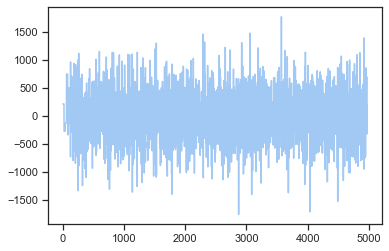

In [182]:
%matplotlib inline
a = [AM_after[i]-AM_before[i] for i in range(len(AM_after))]
plt.plot(a)

(array([ 1.,  4.,  5.,  8., 13., 22., 11., 20., 13.,  4.]),
 array([-1246.1069475 , -1035.42096147,  -824.73497543,  -614.0489894 ,
         -403.36300337,  -192.67701734,    18.00896869,   228.69495472,
          439.38094075,   650.06692678,   860.75291281]),
 <a list of 10 Patch objects>)

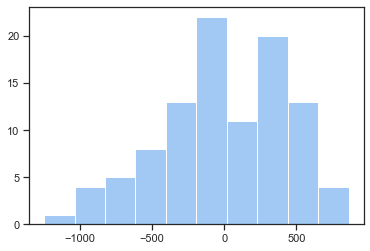

In [183]:
# for each collision, show the difference of angular momentums between two particles before and after hitting 
b= [final_AM[i]-init_AM[i] for i in range(len(final_AM))]
plt.hist(b)

(array([ 9., 12.,  2., 14., 17., 13., 18.,  9.,  5.,  2.]),
 array([-10121.78140621,  -8932.31890544,  -7742.85640466,  -6553.39390388,
         -5363.93140311,  -4174.46890233,  -2985.00640155,  -1795.54390077,
          -606.0814    ,    583.38110078,   1772.84360156]),
 <a list of 10 Patch objects>)

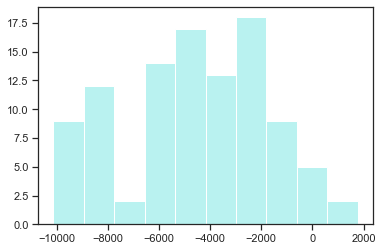

In [341]:
%matplotlib inline
plt.hist(final_AM, color = 'c')
#plt.savefig('AM_final_hist.png', bbox_inches='tight', dpi = 800 )

In [107]:
R=50
T= 10
atoms = init_disk_circle(R,20)
energy_init = 0
for i in range(N):
    energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
AM = simulate_time(R,N,T,atoms)

energy_final = 0
for i in range(N):
    energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    
print('Energy lost: %.10f' %(energy_init-energy_final))     

Energy lost: -0.0000000001


101


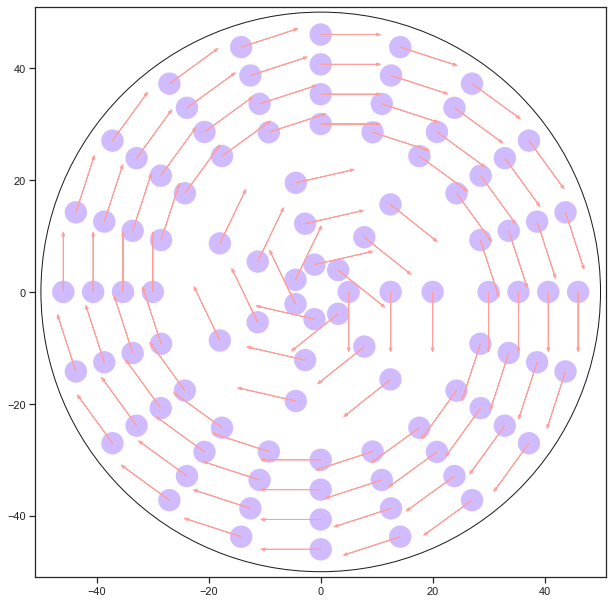

In [146]:
%matplotlib inline
R = 50
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_ylim(-(R+1),(R+1))
ax.set_xlim(-(R+1),(R+1))
ax.add_patch(circle1)
ax.set_aspect(1)

atoms = init_disk_circle(R,10)
print(len(atoms))

circles = [plt.Circle((a.x[0],a.x[1]), radius=a.radius, linewidth=0, color = 'm') for a in atoms ]
for a in atoms:
    ax.arrow(a.x[0],a.x[1], a.v[0],a.v[1], head_width=0.5, head_length=0.7, fc= 'r',ec='r')
c = matplotlib.collections.PatchCollection(circles,match_original=True)
ax.add_collection(c)
#plt.colorbar(c)
plt.savefig('AM_initial.png', bbox_inches='tight', dpi = 800 )

In [334]:
from scipy import fftpack
T = 20
R = 50

pvma= []
ma = []
vs = [20,40,60,80,100,120,140]
periods_storage =[]
for v in vs:
    periods = []
    atoms = init_disk_circle(R,v)
    N = len(atoms)
    init_AM = [ang_momentum(i,-1) for i in range(N)]
    ma.append(sum(init_AM))
    energy_init = 0
    for i in range(N):
        energy_init = energy_init + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
 
    AM_before,AM_after, tau = simulate_time(R,N,T,atoms)
    
    final_AM = [ang_momentum(i,-1) for i in range(N)]
    energy_final = 0
    for i in range(N):
        energy_final = energy_final + atoms[i].mass * (atoms[i].v[0]**2 + atoms[i].v[1]**2)/2 
    print('Energy lost: %.10f' %(energy_init-energy_final))     
    print(sum(init_AM))
    
    xsx = np.array(xs)
    f_s = len(xsx[0])/T
    for i in range(N):
        a= [xsx[i][t][0]  for t in range(len(xsx[0]))]
        X = fftpack.fft(a)
        freqs = fftpack.fftfreq(len(a)) * f_s
        p = 1/freqs[np.argmax(np.abs(X))]
        periods.append(p)
    pvma.append(np.median(periods))
    periods_storage.append(periods)

Energy lost: 0.0000000001
-66050.00000000006
Energy lost: -0.0000000030
-132100.00000000012
Energy lost: -0.0000000085
-198150.0
Energy lost: 0.0000000034
-264200.00000000023
Energy lost: 0.0000000264
-330249.9999999998
Energy lost: -0.0000000009
-396300.0
Energy lost: -0.0000000786
-462349.99999999965


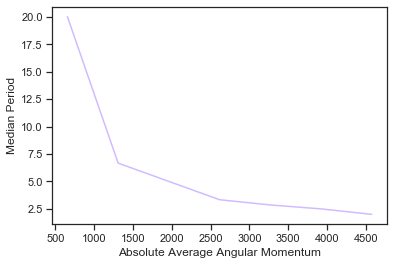

In [340]:
am = [np.abs(ma[i]/N) for i in range(len(ma))]
plt.plot(am, pvma, 'm')
plt.xlabel('Absolute Average Angular Momentum')
plt.ylabel('Median Period')
plt.savefig('AMvRR.png', bbox_inches='tight', dpi = 800 )

11
3.6363636363636367


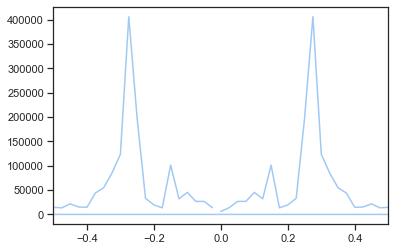

In [330]:
f_s = len(xsx[0])/40
a= [xsx[20][t][0]  for t in range(len(xsx[0]))]
X = fftpack.fft(a)
freqs = fftpack.fftfreq(len(a)) * f_s
plt.plot(freqs, np.abs(X))
plt.xlim(-0.5,0.5)
print(np.argmax(np.abs(X)))
print(1/freqs[np.argmax(np.abs(X))])

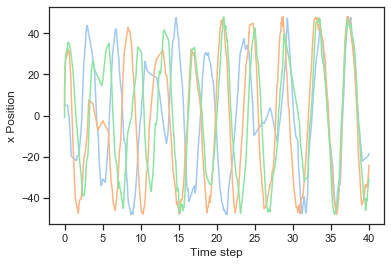

In [347]:
ts = [i*40/len(xsx[0]) for i in range(len(xsx[0]))]
for i in range(0,3):
    a= [xsx[i][t][0]  for t in range(len(xsx[0]))]
    plt.plot(ts,a, label = 'Atom %d'%i)
plt.xlabel('Time step')
plt.ylabel('x Position')
plt.savefig('AM_sines.png', bbox_inches='tight', dpi = 800 )

<IPython.core.display.Javascript object>


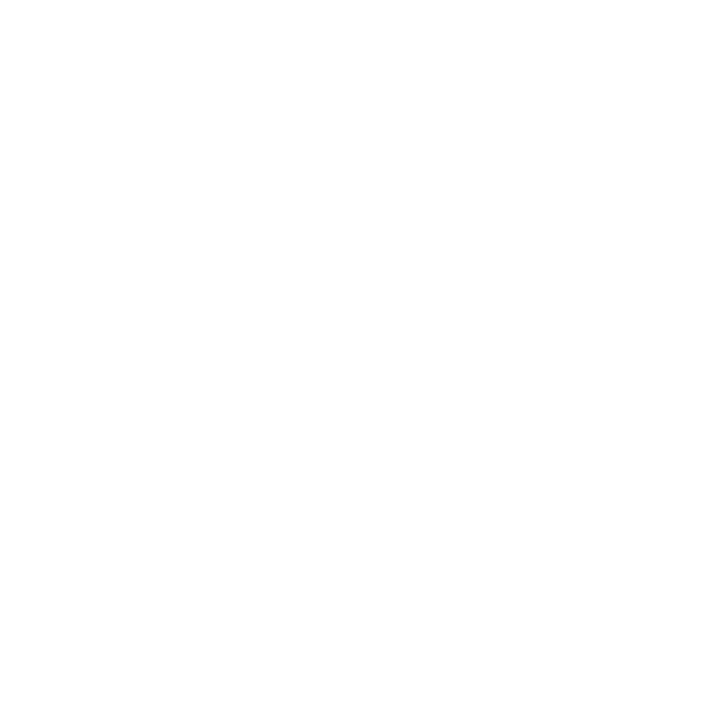

<IPython.core.display.Javascript object>


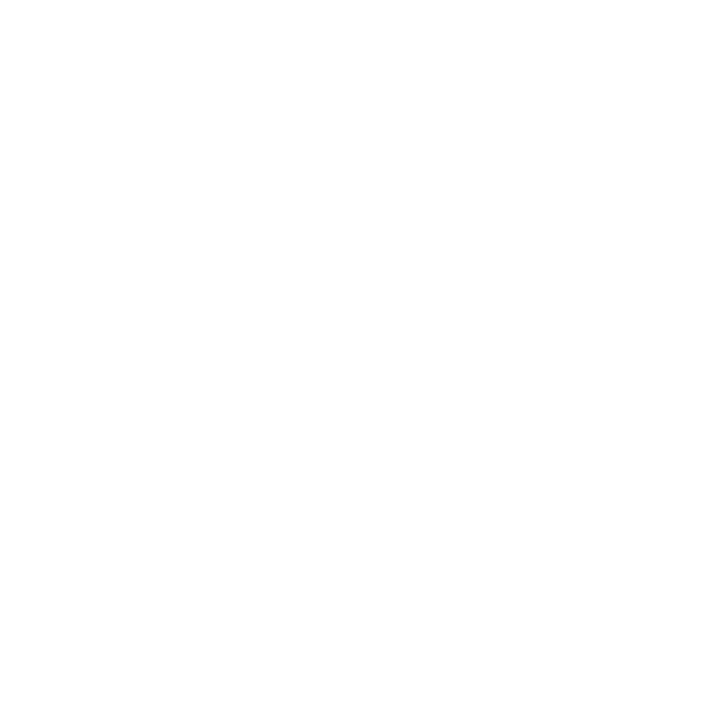

Traceback (most recent call last):
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\janic\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [187]:

%matplotlib notebook

xsx = np.array(xs)
R=50


fig=plt.figure()
ax = plt.axes(xlim=(-(R+1),(R+1)), ylim=(-(R+1),(R+1)))
fig.set_size_inches(10, 10)
circle1 = plt.Circle((0, 0), R, color='k', fill = False)
ax.add_patch(circle1)
ax.set_aspect(1)


#ax = plt.axes(xlim=(0, 40), ylim=(0, 40))
rads = [atoms[i].radius for i in range(N)]
dict_of_circles = {}
for i in range(N):
    dict_of_circles["circle"+str(i+1)] = plt.Circle((xsx[i][0][0], xsx[i][0][1]),2,fc='b')

def init():
    for i in range(N):
        dict_of_circles["circle"+str(i+1)].center = (xsx[i][0][0], xsx[i][0][1])
        ax.add_patch(dict_of_circles["circle"+str(i+1)])
    return dict_of_circles.values()

def animate(i):
    for n in range(N):
        dict_of_circles["circle"+str(n+1)].center = (xsx[n][i][0], xsx[n][i][1])
    return dict_of_circles.values()

anim=animation.FuncAnimation(fig,animate,init_func=init,frames=len(xsx[0]),blit=True)
anim.save(
  filename='test.mp4',
  fps=30,
  dpi=200,
)